<a href="https://colab.research.google.com/github/eckerli/BA_code/blob/main/BA_Eckerli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GANs for finance time series

Framework for generating synthetic time series based on the standard version of 10 GANs

### Setup

In [1]:
#!unzip project.zip
#!pip install tensorflow-addons

import tensorflow as tf
print(tf.config.list_physical_devices("GPU"))
tf.__version__

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


'2.10.1'

In [2]:
from config import *
from generator import make_generator_model
from discriminator import make_discriminator_model
from data import download_data, f_log_return
from data import rolling_window
from training import train
from visualization import *

import keras
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import tensorflow as tf
from pandas.plotting import scatter_matrix, autocorrelation_plot

%load_ext autoreload
%autoreload 2

c:\Users\hbnmo\.conda\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\hbnmo\.conda\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to ma

### Load and prepare the dataset

In [3]:
# must be from ['dcgan', 'lsgan', 'sagan', 'wgan', 'wgan_gp', 'dragan', 'ragan', 'ralsgan', 'ylgan', 'biggan', 'biggan_deep', 'transgan']
# 'dcgan': standard deep convolutional GAN
# 'lsgan': least square GAN, a loss variant
# 'sagan': self-attention GAN, a structure variant with dense attention
# 'wgan': Wasserstein GAN, a loss variant
# 'wgan_gp': Wasserstein GAN with gradient penalty, a loss variant
# 'dragan': deep regret analytic GAN, a loss variant similar to 'wgan_gp'
# 'ragan', 'ralsgan': loss function improvements of 'dcgan' and 'lsgan' with realistic factors
# 'ylgan': your local GAN, a structure variant with sparse attention
# 'biggan', 'biggan_deep': larger versions of 'sagan'
# 'transgan': transformer GAN, a strucutre variant with transformer blocks

choice = 'dcgan'

Use the (as yet untrained) generator to create an image.

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

tf.Tensor([[0.00899549]], shape=(1, 1), dtype=float32)


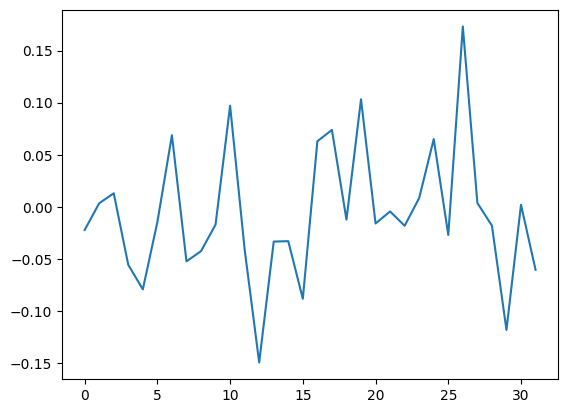

In [4]:
generator = make_generator_model(choice)
discriminator = make_discriminator_model(choice)

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
decision = discriminator(generated_image)

plt.plot(generated_image[0, :, 0])
print(decision)

In [5]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              103424    
                                                                 
 reshape (Reshape)           (None, 4, 256)            0         
                                                                 
 batch_normalization (BatchN  (None, 4, 256)           1024      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4, 256)            0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 8, 128)           163968    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 128)           5

In [6]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 16, 32)            1632      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 64)             10240     
                                                                 
 batch_normalization_4 (Batc  (None, 8, 64)            256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 64)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 4, 128)            40960     
                                                      

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

### **Real data -- S&P 500 daily**
Use daily data for the S&P 500 index
1) download data from yahoo
2) do a descriptive analysis of the data
3) Choose one GAN to start with
3) train the GAN
4) evaluate the outcome

#### **Retrieve data from Yahoo finance**

In [3]:
ticker_list = ['AAPL', 'MSFT', 'PFE', 'MRK', 'JPM', 'BAC', 'KO', 'PEP', 'CVX', 'XOM'] # ['^GSPC']
name_list = ticker_list # ['S&P500']
start_date = '2000-01-01'
end_date = '2023-11-01'
ohlc_data = 'Adj Close'

In [4]:
prices_returns = download_data(start_date, end_date, ticker_list, name_list, ohlc_data)
f_log_return(prices_returns)
log_returns = prices_returns.iloc[:,len(ticker_list):]
prices = prices_returns.iloc[:,:len(ticker_list)]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
prices #.pct_change().to_numpy()[1:,0]

,AAPL,MSFT,PFE,MRK,JPM,BAC,KO,PEP,CVX,XOM
Date,,,,,,,,,,
2000-01-03,0.847207,36.132271,13.257619,27.068480,24.062206,13.037565,14.549595,20.373213,17.326847,18.499046
2000-01-04,0.775779,34.911709,12.763709,26.117842,23.534248,12.263723,14.565724,19.855255,17.326847,18.144705
2000-01-05,0.787131,35.279808,12.971669,27.143549,23.388968,12.398298,14.694757,19.371822,17.637634,19.133879
2000-01-06,0.719014,34.097996,13.439587,27.368696,23.721025,13.458128,14.710891,20.235100,18.388723,20.123058
2000-01-07,0.753073,34.543610,14.349422,29.995478,24.156841,13.104860,15.678715,20.787584,18.712473,20.064001
...,...,...,...,...,...,...,...,...,...,...
2023-10-25,170.874893,339.979980,30.321198,103.629997,140.399994,25.347691,55.676666,161.121414,154.253052,107.606010
2023-10-26,166.670425,327.225861,30.745478,105.550003,140.759995,25.913177,55.339352,160.188522,153.144669,106.624985
2023-10-27,167.998672,329.141968,29.709446,102.820000,135.690002,24.970699,54.803623,158.412064,142.852554,104.593567


## **Exploratory data analysis**

Initial investigations on data so as to discover patterns, to spot anomalies, to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

##### Closing prices

In [6]:
prices.describe()

,AAPL,MSFT,PFE,MRK,JPM,BAC,KO,PEP,CVX,XOM
count,5996.000000,5996.000000,5996.000000,5996.000000,5996.000000,5996.000000,5996.000000,5996.000000,5996.000000,5996.000000
mean,33.491242,70.005377,20.520775,39.463421,52.837559,21.376117,27.316912,68.028243,62.441505,47.392741
std,49.365793,87.242002,10.359897,23.674459,39.826157,9.696754,14.786620,44.087568,37.729437,20.949289
min,0.198599,11.304624,6.358039,12.106306,8.497107,2.549809,9.998874,16.920134,14.110684,15.106494
25%,1.809115,19.018150,12.348656,22.136581,24.203057,12.970544,13.940203,33.521328,29.927344,32.086490
50%,12.146343,23.588385,17.530429,29.723141,31.397037,21.035034,23.436141,47.177904,61.515568,49.199722
75%,37.734451,77.804686,26.709237,49.496136,81.277205,28.823729,36.820285,93.422012,82.428505,58.970616
max,195.926956,358.003876,56.748573,116.798065,161.703857,46.799236,62.817856,191.935333,180.690491,119.110809


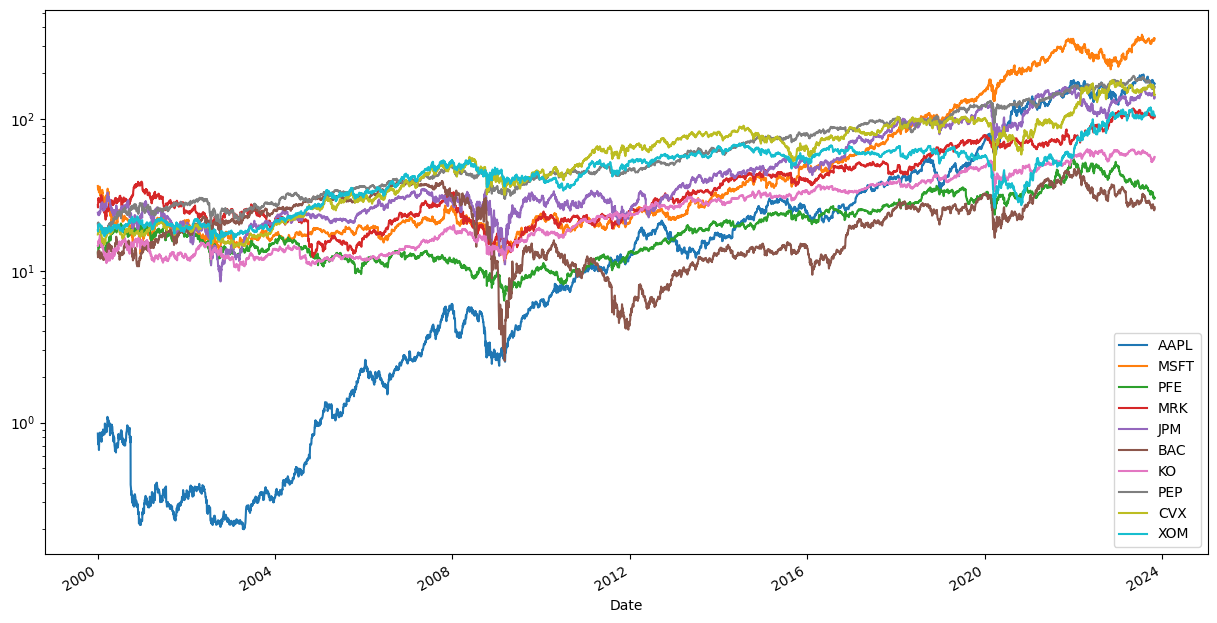

In [7]:
_ = prices.plot(figsize=(15, 8))
plt.yscale("log")

##### Log returns

In [8]:
log_returns.describe()

,Log Returns 0,Log Returns 1,Log Returns 2,Log Returns 3,Log Returns 4,Log Returns 5,Log Returns 6,Log Returns 7,Log Returns 8,Log Returns 9
count,5996.000000,5996.000000,5996.000000,5996.000000,5996.000000,5996.000000,5996.000000,5996.000000,5996.000000,5996.000000
mean,0.088473,0.037261,0.013705,0.022239,0.029257,0.011596,0.022491,0.034584,0.035341,0.028939
std,2.568204,1.929383,1.587838,1.678654,2.377897,2.797917,1.309975,1.262850,1.759002,1.675754
min,-73.124787,-16.957662,-11.817146,-31.170937,-23.227759,-34.205877,-10.603820,-12.705344,-25.006225,-15.027128
25%,-1.021143,-0.826047,-0.755952,-0.741577,-0.899970,-0.973087,-0.550622,-0.555257,-0.802660,-0.780609
50%,0.089160,0.035375,0.000000,0.030493,0.021724,0.028691,0.043248,0.032837,0.077308,0.043726
75%,1.287066,0.938654,0.797121,0.840010,0.970992,1.018821,0.626843,0.632857,0.908144,0.873889
max,13.019371,17.869151,10.305465,12.250827,22.391723,30.209594,12.997076,13.861881,20.490377,15.863069


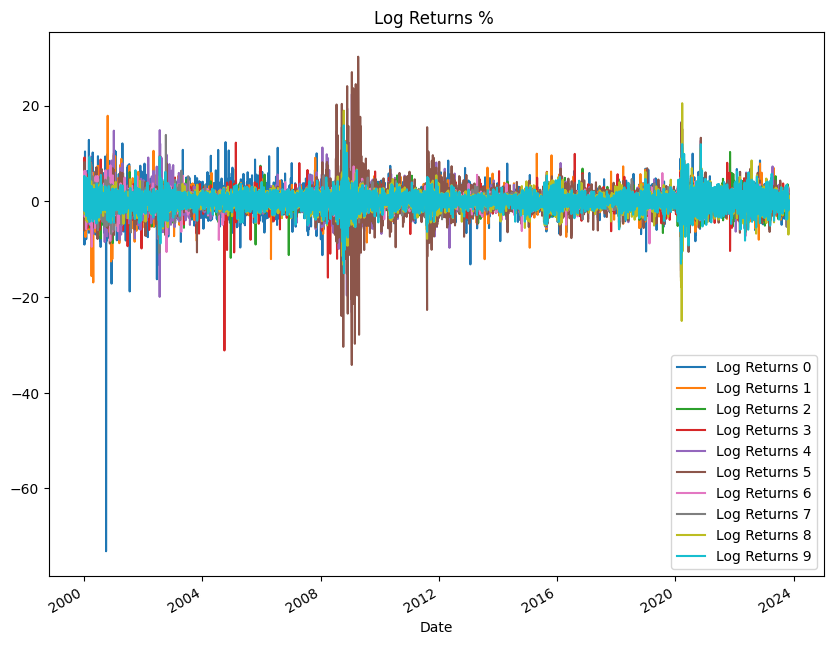

In [9]:
_ = log_returns.plot(figsize=(10, 8), title = "Log Returns % ")

In [14]:
# Auto correlation of log returns
# assumed to be close to zero for real time series (linear unpredictability)
#autocorrelation_plt(log_returns)

In [15]:
#_ = scatter_matrix(log_returns, figsize=(10, 10), diagonal='kde')

In [10]:
# Cross correlation
log_returns.corr()

,Log Returns 0,Log Returns 1,Log Returns 2,Log Returns 3,Log Returns 4,Log Returns 5,Log Returns 6,Log Returns 7,Log Returns 8,Log Returns 9
Log Returns 0,1.000000,0.466059,0.214482,0.201513,0.352668,0.306651,0.228028,0.202621,0.264732,0.263700
Log Returns 1,0.466059,1.000000,0.329659,0.291633,0.447444,0.374081,0.338310,0.347034,0.378943,0.365453
Log Returns 2,0.214482,0.329659,1.000000,0.537754,0.373922,0.352358,0.365821,0.400981,0.381068,0.397756
Log Returns 3,0.201513,0.291633,0.537754,1.000000,0.337209,0.294212,0.352988,0.388440,0.367471,0.370546
Log Returns 4,0.352668,0.447444,0.373922,0.337209,1.000000,0.787650,0.341898,0.328762,0.468695,0.448679
Log Returns 5,0.306651,0.374081,0.352358,0.294212,0.787650,1.000000,0.300300,0.293375,0.445677,0.420152
Log Returns 6,0.228028,0.338310,0.365821,0.352988,0.341898,0.300300,1.000000,0.599866,0.379364,0.404191
Log Returns 7,0.202621,0.347034,0.400981,0.388440,0.328762,0.293375,0.599866,1.000000,0.369741,0.385387
Log Returns 8,0.264732,0.378943,0.381068,0.367471,0.468695,0.445677,0.379364,0.369741,1.000000,0.838612
Log Returns 9,0.263700,0.365453,0.397756,0.370546,0.448679,0.420152,0.404191,0.385387,0.838612,1.000000


#### **Transform Data and Convert to Tensor**

In [11]:
power = 1

scale = np.sign(log_returns) * np.power(np.abs(log_returns), 1/power)
def transform(x):
    x1 = np.sign(x) * np.power(np.abs(x), 1/power)
    x2 = (x1 - scale.mean())/scale.std()
    return x2

def inv_transform(z):
    z1 = z*scale.std().to_numpy() + scale.mean().to_numpy()
    z2 = np.sign(z1) * np.abs(z1)**(power)
    return z2

x = log_returns + np.pi
np.abs(x - inv_transform(transform(x))).max()

Log Returns 0    1.776357e-15
Log Returns 1    8.881784e-16
Log Returns 2    8.881784e-16
Log Returns 3    3.552714e-15
Log Returns 4    3.552714e-15
Log Returns 5    3.552714e-15
Log Returns 6    1.776357e-15
Log Returns 7    1.776357e-15
Log Returns 8    1.776357e-15
Log Returns 9    1.776357e-15
dtype: float64

In [12]:
# TODO: transformation
log_returns_tranformed = transform(log_returns)
data = rolling_window(np.asarray(log_returns_tranformed))

In [13]:
num_examples_to_generate = 16 # maximum value due to plotting
# Get seed
seed = tf.random.normal([num_examples_to_generate, noise_dim])
test = [[plot_hist, seed]]

# Convert to tensor
train_data = np.stack(data, axis=0)
#train_data = tf.convert_to_tensor(train_data, np.float32)
#train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## **Train the Model**

In [14]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


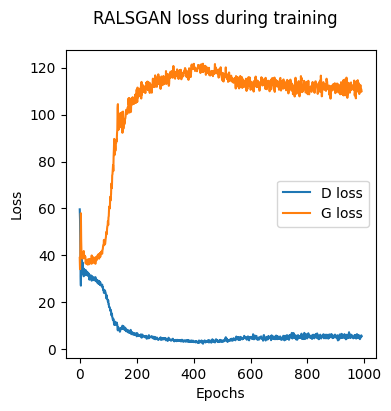

Time for last 10 epochs (epoch 991 now) is 12.950554132461548 sec
ylgan
FAILURE FOR ylgan!


In [9]:
#choices = ['dcgan', 'lsgan', 'wgan', 'wgan_gp', 'transgan', 'ragan', 'sagan', 'dragan', 'biggan', 'biggan_deep', 'ralsgan', 'ylgan']
choices = ['biggan', 'biggan_deep', 'ralsgan', 'ylgan']

EPOCHS = 1000

failures = []
# Input for the generator: some random noise, called latent data
num_examples_to_generate = 16 # maximum value due to plotting
G_losses = {}; D_losses = {};

train_data = tf.convert_to_tensor(train_data, np.float32)
with tf.device("CPU:0"):
    train_data = tf.convert_to_tensor(train_data, np.float32)
    train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

    for choice in choices:
        print(choice)
        try:
            generator = make_generator_model(choice)
            discriminator = make_discriminator_model(choice)

            # Global variables for the loss
            G_loss = []; D_loss = [];

            # Train the data
            train(generator, discriminator, G_loss, D_loss, train_dataset, test, EPOCHS, choice)
            G_losses[choice] = np.array(G_loss)
            D_losses[choice] = np.array(D_loss)
        except:
            failures.append(choice)
            print(f"FAILURE FOR {choice}!")

In [10]:
failures

['ylgan']

In [ ]:
raise Exception()

# Generating general model stats

In [28]:
#with open('saved_dictionary.pkl', 'wb') as f:
#    pickle.dump(dictionary, f)

#with open('saved_dictionary.pkl', 'rb') as f:
#    loaded_dict = pickle.load(f)

In [15]:
# Using the trained generator to compute new synthetic data
def get_G_df(generator, data):
    # Getting generated data
    noise = np.random.randn(int(len(data)/data_dim), noise_dim)
    predictions = generator(noise, training=True) # TRAINING TRUE OR FALSE

    # TODO: added inverse transform
    predictions = inv_transform(predictions)

    result = tf.squeeze(predictions) # Given a tensor input, this operation returns a tensor of the same type with all dimensions of size 1 removed.
    temp = (result.numpy())
    generated_data = np.array([item for sublist in temp for item in sublist]) # temp is the list getting flattened

    df_generated = pd.DataFrame(generated_data, columns=[f'G {name}' for name in name_list])
    return df_generated

## Generate runs

In [15]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

num_runs = 100

# TODO: remove indexing
for folder in os.listdir("models"):#[:2]: # TODO: remove indexing
    dfs = {}
    names = os.listdir(os.path.join("models", folder))

    for i, name in enumerate(names):
        full_name = os.path.join("models", folder, name)
        try:
            model = keras.models.load_model(full_name)
        except:
            continue

        dfs[name] = {}
        for num in range(num_runs):
            dfs[name][num] = get_G_df(model, data)
            print(f"\rLoaded model {i} out of {len(names)} from {folder}", end=50*" ")

    if dfs:
        with open(os.path.join("runs", f"{folder}_runs.pkl"), 'wb') as f:
            pickle.dump(dfs, f)
        print(f"\rPickled {folder}!", end=50*" "+"\n")
    else:
        print(f"\rSkipped {folder}!", end=50*" "+"\n")
    del dfs

Pickled dcgan!                                                                         
Pickled dragan!                                                                         
Pickled lsgan!                                                                         
Pickled ragan!                                                                         
Pickled ralsgan!                                                                         
Pickled wgan!                                                                         
Pickled wgan_gp!                                                                         


## Generate metrics

In [143]:
def apply_metric(runs_dict, f, num):
    results = {}
    g_runs = [run.to_numpy() for run in runs_dict.values()]
    for i, ticker in enumerate(ticker_list):
        if num == 1:
            results[ticker] = [f(run[:,i]) for run in g_runs]
        elif num == 2:
            results[ticker] = [f(log_returns.iloc[:,i], run[:,i]) for run in g_runs]
        elif num == -1:
            results[ticker] = [f(run[1:,i], run[:-1,i]) for run in g_runs]
        else:
            raise NotImplementedError
    return results

#def ks(runs_dict):
#    ks_results = {}
#    for i, ticker in enumerate(ticker_list):
#        ks_results[ticker] = [stats.ks_2samp((log_returns.iloc[:,i]), g_data.to_numpy()[:,i]) for g_data in runs_dict.values()]
#    return ks_results

In [28]:
f_mean = lambda x: apply_metric(x, np.mean, 1)
f_std = lambda x: apply_metric(x, np.std, 1)
f_skew = lambda x: apply_metric(x, stats.skew, 1)
f_kurtosis = lambda x: apply_metric(x, stats.kurtosis, 1)

f_autocorr = lambda x: apply_metric(x, stats.pearsonr, -1)

f_ks = lambda x: apply_metric(x, stats.ks_2samp, 2)

def f_corr(runs_dict):
    results = {}
    g_runs = [run.to_numpy() for run in runs_dict.values()]
    results["G_log"] = [pd.DataFrame({f"G {name}": run[:,i] for (i, name) in enumerate(ticker_list)}).corr() for run in g_runs]
    results["G_abs"] = [pd.DataFrame({f"G |{name}|": np.abs(run[:,i]) for (i, name) in enumerate(ticker_list)}).corr() for run in g_runs]
    return results

In [29]:
f_names = ["mean", "std", "skew", "kurtosis", "autocorr", "ks", "corr"]
f_stats = [f_mean, f_std, f_skew, f_kurtosis, f_autocorr, f_ks, f_corr]

# TODO: remove indexing
for dict_name in os.listdir("runs"):#[:1]: # TODO: remove indexing
    metrics = {stat_name: {} for stat_name in f_names}
    with open(os.path.join("runs", dict_name), 'rb') as f:
        df_runs = pickle.load(f)

        for i, (model_name, model_dict) in enumerate(df_runs.items()):
            for (m_name, m_f) in zip(f_names, f_stats):
                metrics[m_name][model_name] = m_f(model_dict)

            print(f"\rGenerated metrics for model {i+1} out of {len(df_runs)} for {dict_name}", end=50*" ")
        with open(os.path.join("metrics", f"{dict_name}_metrics.pkl"), 'wb') as f:
            pickle.dump(metrics, f)
        print(f"\rAnalyzed {dict_name}!", end=50*" "+"\n")
    del metrics


Analyzed dcgan_runs.pkl!                                                                                       
Analyzed dragan_runs.pkl!                                                                                       
Analyzed lsgan_runs.pkl!                                                                                       
Analyzed ragan_runs.pkl!                                                                                       
Analyzed ralsgan_runs.pkl!                                                                                       
Analyzed wgan_gp_runs.pkl!                                                                                       
Analyzed wgan_runs.pkl!                                                                                       


In [76]:
df_metrics["corr"]['dcgan_0.keras'].keys()

dict_keys(['G_log', 'G_abs'])

In [83]:
cmd(log_returns.corr(), df_metrics["corr"]['dcgan_300.keras']["G_log"][0])

0.030530986507364077

# Pulling metrics

In [133]:
def reduce(ticker_dict, f, matrix_name=None):
    if matrix_name is not None:
        mean_scores = np.array([f(matrix) for matrix in ticker_dict[matrix_name]])
    else:
        all_scores = np.array([[f(index, score) for score in score_list] for (index, score_list) in enumerate(ticker_dict.values())])
        #print("all_scores ", all_scores.shape)
        mean_scores = np.mean(all_scores, axis=0)
    #print("mean_scores ", mean_scores.shape)
    best_run_index = np.argmax(mean_scores)
    model_score_dict = {
        "mean": mean_scores.mean(),
        "std": mean_scores.std(),
        "scores": mean_scores,
        "best_run_index": best_run_index,
        "best_run_score": mean_scores[best_run_index]
    }
    return model_score_dict

log_returns_pct = lambda index: log_returns.iloc[:,index][np.abs(log_returns.iloc[:,index]) < np.percentile(np.abs(log_returns.iloc[:,index]), 99.9)]

f_mean_reduce = lambda index, score: -(score - np.mean(log_returns_pct(index)))**2
f_std_reduce = lambda index, score: -(score - np.std(log_returns_pct(index)))**2
f_skew_reduce = lambda index, score: -(score - stats.skew(log_returns_pct(index)))**2
f_kurtosis_reduce = lambda index, score: -(score - stats.kurtosis(log_returns_pct(index)))**2

f_ks_reduce = lambda index, score: np.log(score.pvalue)

f_autocorr_reduce = lambda index, score: -(score.statistic - stats.pearsonr(log_returns.iloc[1:,index], log_returns.iloc[:-1,index]).statistic)**2

f_corrlog_reduce = lambda matrix: -cmd(matrix, log_returns.corr())
f_corrabs_reduce = lambda matrix: -cmd(matrix, np.abs(log_returns).corr())

In [171]:
f_names2 = ["mean", "std", "skew", "kurtosis", "autocorr", "ks"]
f_reducers = [f_mean_reduce, f_std_reduce, f_skew_reduce, f_kurtosis_reduce, f_autocorr_reduce, f_ks_reduce]

scores = {}
for dict_name in os.listdir("metrics"): # TODO: remove indexing
    if "old" in dict_name:
        continue
    scores[dict_name] = {}
    with open(os.path.join("metrics", dict_name), 'rb') as f:
        df_metrics = pickle.load(f)

        scores[dict_name]["corrlog"] = {}
        scores[dict_name]["corrabs"] = {}
        for model_name in df_metrics["corr"].keys():
            scores[dict_name]["corrlog"][model_name] = reduce(df_metrics["corr"][model_name], f_corrlog_reduce, matrix_name="G_log")
            scores[dict_name]["corrabs"][model_name] = reduce(df_metrics["corr"][model_name], f_corrabs_reduce, matrix_name="G_abs")

        for metric, f_reducer in zip(f_names2, f_reducers):
            scores[dict_name][metric] = {}

            for model_name in df_metrics[metric].keys():
                scores[dict_name][metric][model_name] = reduce(df_metrics[metric][model_name], f_reducer)

            #keys, values = np.array(list(scores[dict_name][metric].items())).T
            #max_arg = np.argmax(values)
            #print(f"{dict_name} {keys[max_arg]} {metric} score:", values[max_arg])

    print(f"\rDone scoring {dict_name}!", end=50*" ")

    with open(f"scores.pkl", 'wb') as f:
        pickle.dump(scores, f)

with open(f"scores.pkl", 'wb') as f:
        pickle.dump(scores, f)

Done scoring dcgan_runs.pkl_metrics.pkl!                                                  

# Plotting metrics

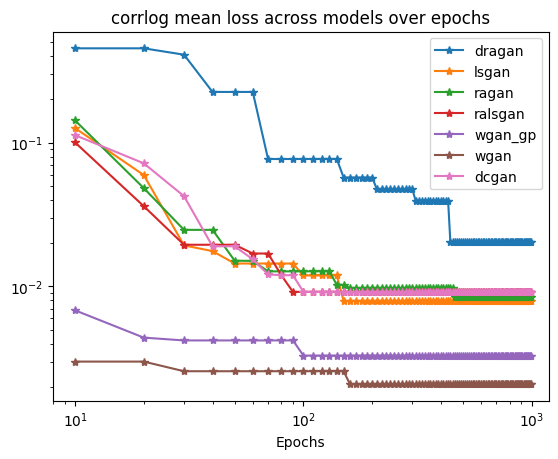

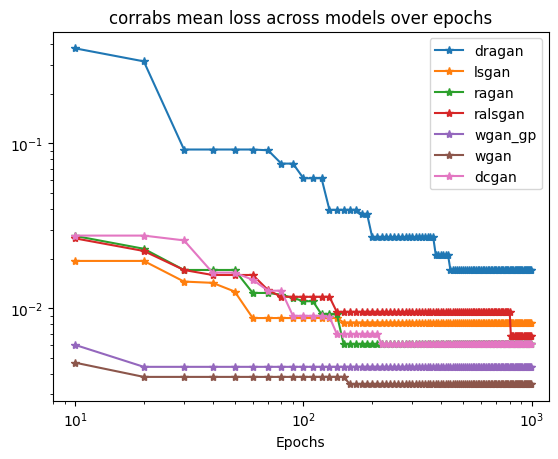

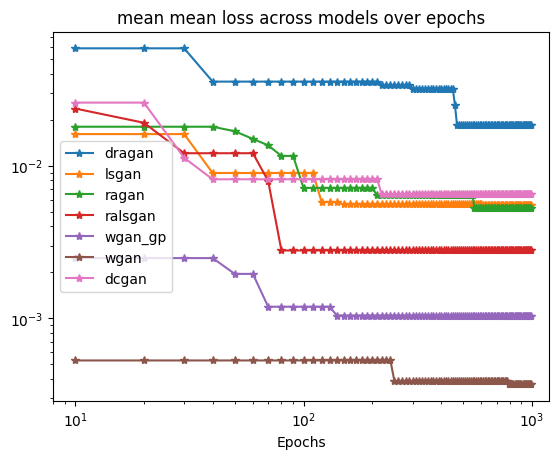

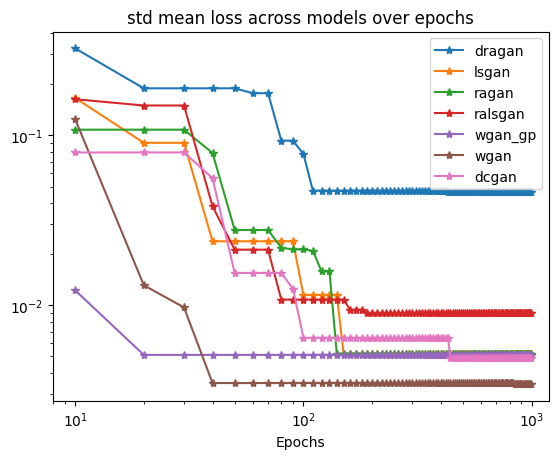

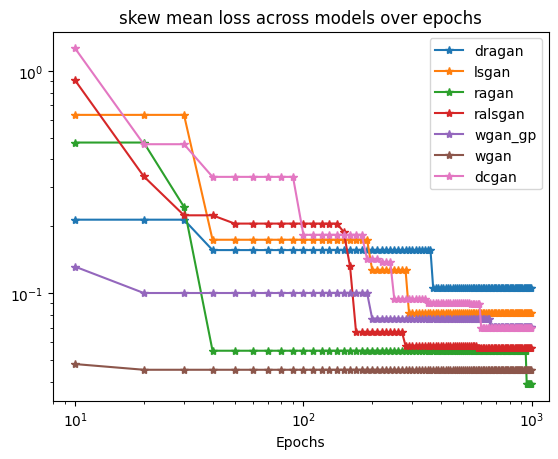

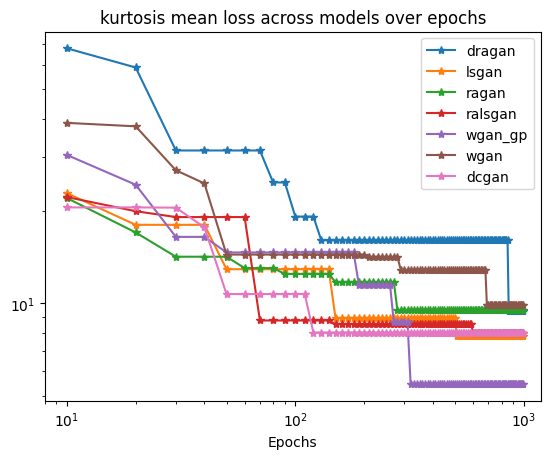

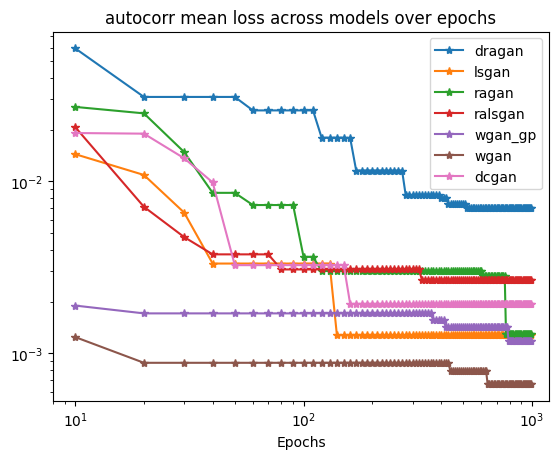

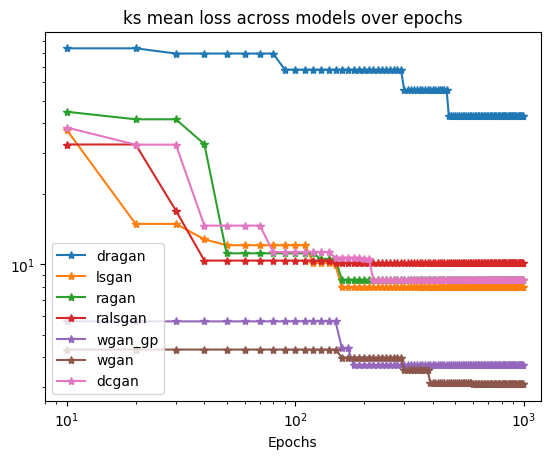

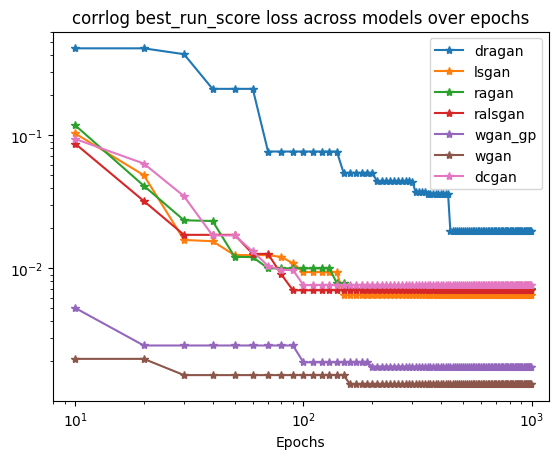

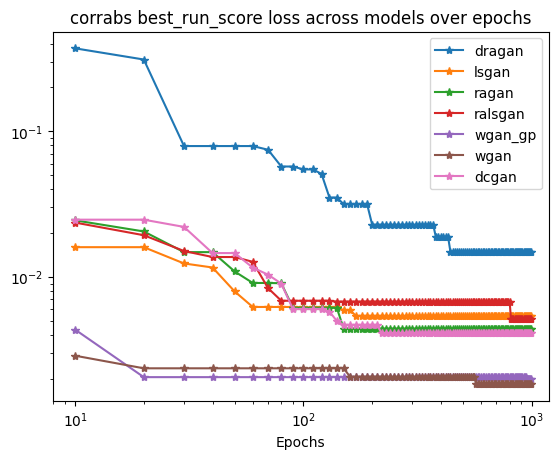

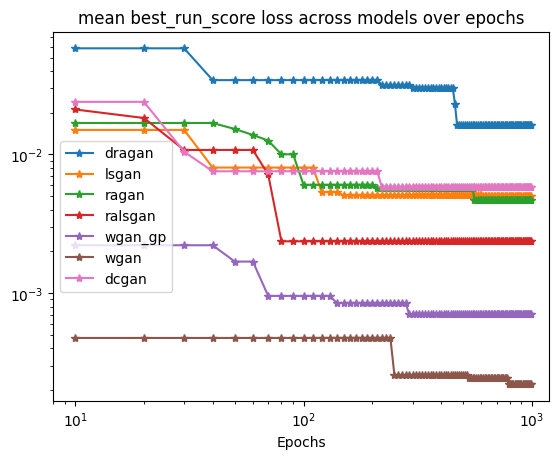

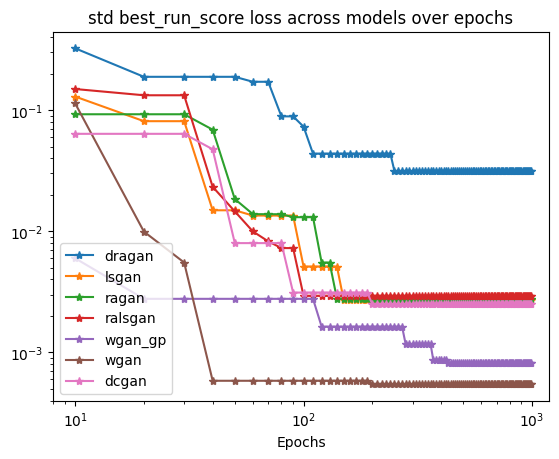

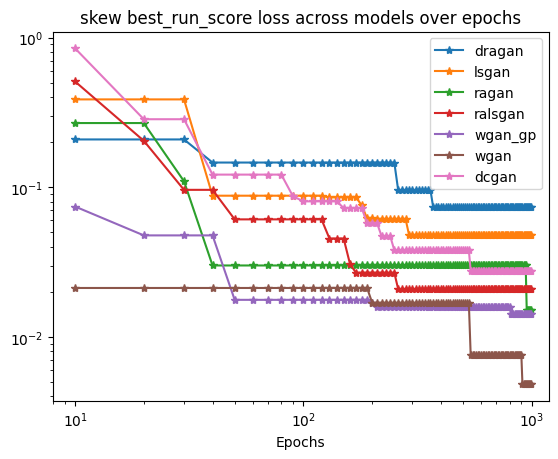

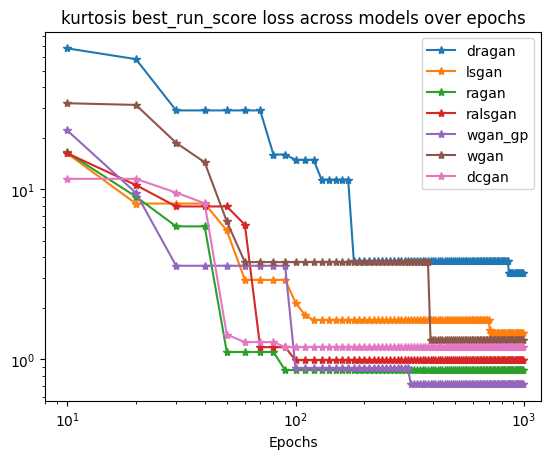

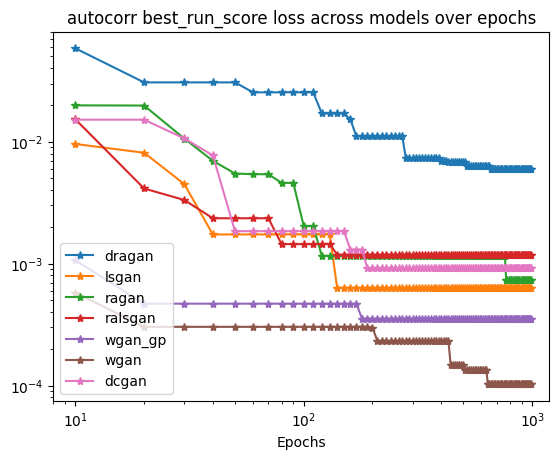

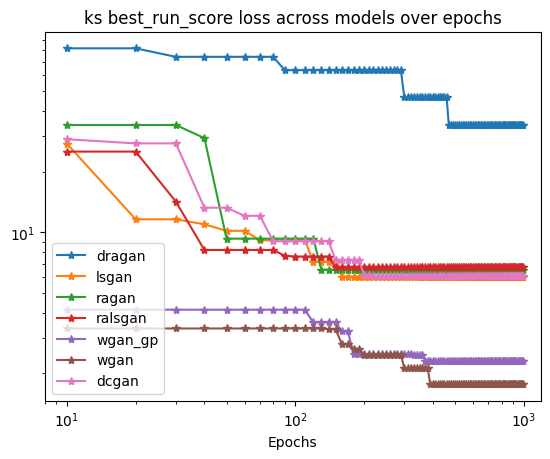

In [17]:
best_scores = {}

epochs = np.arange(0+10, 990+10, 10)
with open(f"scores.pkl", 'rb') as f:
    scores = pickle.load(f)
    for metric_type in ["mean", "best_run_score"]:
        best_scores[metric_type] = {}

        for metric in scores[list(scores.keys())[0]].keys(): # scores[model_class].keys()
            best_scores[metric_type][metric] = {}

            for model_class in scores.keys():
                if "old" in model_class:
                    continue
                model_class_name = model_class.split("_")[0] if "_gp" not in model_class else "wgan_gp"
                model_names = [f"{model_class_name}_{epoch}.keras" for epoch in epochs]

                if metric_type == "mean":
                    values = np.array([scores[model_class][metric][name]["mean"] for name in model_names])
                    values = np.maximum.accumulate(values)

                elif metric_type == "best_run_score":
                    values = np.array([scores[model_class][metric][name]["best_run_score"] for name in model_names])
                    values = np.maximum.accumulate(values)

                best_scores[metric_type][metric][model_class_name] = values[-1]
                plt.plot(epochs, -values, "*-", label=model_class_name)

            plt.title(f"{metric} {metric_type} loss across models over epochs")
            plt.xlabel("Epochs")
            plt.xlim(epochs[0]*0.8, epochs[-1]*1.2)
            plt.xscale("log")
            plt.yscale("log")
            plt.legend()
            plt.show()

In [18]:
metrics = ['mean', 'std', 'skew', 'kurtosis', 'ks', 'autocorr', 'corrlog', 'corrabs']

for metric in metrics:
    models = best_scores["mean"][metric]
    model_names = np.array(list(models.keys()))
    values = [models[key] for key in model_names]

    argsort = np.argsort(values)[::-1]
    string = " & ".join([metric] + list(model_names[argsort])).upper() + " \\\ \hline"
    string = string.replace("_", "-").replace("GAN", "").replace(" LS", " GAN")
    print(string)

MEAN & W & W-GP & RALS & RA & GAN & DC & DRA \\ \hline
STD & W & DC & W-GP & GAN & RA & RALS & DRA \\ \hline
SKEW & RA & W & RALS & DC & W-GP & GAN & DRA \\ \hline
KURTOSIS & W-GP & GAN & RALS & DC & DRA & RA & W \\ \hline
KS & W & W-GP & GAN & DC & RA & RALS & DRA \\ \hline
AUTOCORR & W & W-GP & GAN & RA & DC & RALS & DRA \\ \hline
CORRLOG & W & W-GP & GAN & RA & RALS & DC & DRA \\ \hline
CORRABS & W & W-GP & RA & DC & RALS & GAN & DRA \\ \hline


## **Model evaluation**

In [19]:
model_class = "wgan_gp"

for dict_name in [f"{model_class}_runs.pkl"]: #os.listdir("runs"):#[:1]: # TODO: remove indexing
    with open(os.path.join("runs", dict_name), 'rb') as f:
        df_runs = pickle.load(f)

bests = []
my_scores = {}

epochs = np.arange(10, 990+10, 10)
folder = f'{model_class}_runs.pkl_metrics.pkl'

#metrics = ["corrlog", "corrabs"] #scores[folder].keys() # TODO: clustering and matrix figures
metrics = ["mean", "std", "skew", "kurtosis"]

for metric in metrics:
    my_scores[metric] = -np.array([scores[folder][metric][f"{model_class}_{epoch}.keras"]["scores"] for epoch in epochs]).flatten()

epoch_scores = np.prod(np.array(list(my_scores.values())), axis=0)
best_epoch = 10 + 10 * (np.argmin(epoch_scores) // 100)
index = np.argmin(epoch_scores) % 100
print(best_epoch, index)
assert((best_epoch-10)*10 + index == np.argmin(epoch_scores))

filename = f"{model_class}_{best_epoch}.keras"
df_generated = df_runs[filename][index]
generated_data = df_generated.to_numpy()

210 66


In [272]:
#generator.save(f"generator_{choice}{EPOCHS}.keras")
#import keras
#model = keras.models.load_model('generator.keras')

In [20]:
#df_generated = get_G_df(generator, data)
df_generated.describe()

,G AAPL,G MSFT,G PFE,G MRK,G JPM,G BAC,G KO,G PEP,G CVX,G XOM
count,5952.000000,5952.000000,5952.000000,5952.000000,5952.000000,5952.000000,5952.000000,5952.000000,5952.000000,5952.000000
mean,0.118922,0.079766,0.015419,-0.047245,0.022089,0.057131,0.016892,0.035372,-0.017946,0.015087
std,2.536562,1.905504,1.624069,1.659441,2.309689,2.576838,1.245196,1.212973,1.724423,1.585116
min,-20.772987,-17.989784,-10.803474,-14.125614,-21.329834,-34.854000,-9.279135,-13.068917,-18.895638,-15.407176
25%,-1.210606,-0.918341,-0.878081,-0.977235,-1.010209,-1.080714,-0.637091,-0.598592,-0.869344,-0.793147
50%,0.118167,0.103166,0.045680,-0.019934,0.097804,0.082316,0.042165,0.036278,-0.020513,-0.008701
75%,1.472916,1.088323,0.918398,0.892630,1.137728,1.235173,0.686300,0.671370,0.812554,0.808922
max,19.197998,12.577980,12.582766,9.984851,21.792337,26.282024,9.023683,8.871020,13.795955,14.887416


In [21]:
log_returns.describe()

,Log Returns 0,Log Returns 1,Log Returns 2,Log Returns 3,Log Returns 4,Log Returns 5,Log Returns 6,Log Returns 7,Log Returns 8,Log Returns 9
count,5996.000000,5996.000000,5996.000000,5996.000000,5996.000000,5996.000000,5996.000000,5996.000000,5996.000000,5996.000000
mean,0.088473,0.037261,0.013705,0.022239,0.029257,0.011596,0.022491,0.034584,0.035341,0.028939
std,2.568204,1.929383,1.587838,1.678654,2.377897,2.797917,1.309975,1.262850,1.759002,1.675754
min,-73.124787,-16.957662,-11.817146,-31.170937,-23.227759,-34.205877,-10.603820,-12.705344,-25.006225,-15.027128
25%,-1.021143,-0.826047,-0.755952,-0.741577,-0.899970,-0.973087,-0.550622,-0.555257,-0.802660,-0.780609
50%,0.089160,0.035375,0.000000,0.030493,0.021724,0.028691,0.043248,0.032837,0.077308,0.043726
75%,1.287066,0.938654,0.797121,0.840010,0.970992,1.018821,0.626843,0.632857,0.908144,0.873889
max,13.019371,17.869151,10.305465,12.250827,22.391723,30.209594,12.997076,13.861881,20.490377,15.863069


##### KS-Test
This tests whether 2 samples are drawn from the same distribution. Note that the distribution is assumed to be continuous.

This is the two-sided test, one-sided tests are not implemented. The test uses the two-sided asymptotic Kolmogorov-Smirnov distribution.

If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

In [60]:
percentile = lambda x: x#[(np.percentile(x, 0.1) < x) & (x < np.percentile(x, 99.9))]
ks_results = [stats.ks_2samp(percentile(log_returns.iloc[:,i]), generated_data[:,i]) for i in range(len(name_list))]
ks_results # comparing real data to synthetic data

[KstestResult(statistic=0.03774010182415517, pvalue=0.00038847616887401944, statistic_location=-0.7875152230262756, statistic_sign=-1),
 KstestResult(statistic=0.03742279799436183, pvalue=0.00044812338243701547, statistic_location=0.48627832205220695, statistic_sign=1),
 KstestResult(statistic=0.033847946121787285, pvalue=0.002061272160500379, statistic_location=-1.1248701810836792, statistic_sign=-1),
 KstestResult(statistic=0.05706358002108933, pvalue=6.6852902683660465e-09, statistic_location=-0.8600088357925415, statistic_sign=-1),
 KstestResult(statistic=0.03878537752767078, pvalue=0.0002406100946631656, statistic_location=0.4820223321275714, statistic_sign=1),
 KstestResult(statistic=0.04142131941007267, pvalue=6.783367494811019e-05, statistic_location=1.1910804839606088, statistic_sign=1),
 KstestResult(statistic=0.030752804737208317, pvalue=0.006828435685121873, statistic_location=-0.7036495804786682, statistic_sign=-1),
 KstestResult(statistic=0.019008752250604347, pvalue=0.22

In [61]:
" & ".join([f"{ks.pvalue:.2}" for ks in ks_results])

'0.00039 & 0.00045 & 0.0021 & 6.7e-09 & 0.00024 & 6.8e-05 & 0.0068 & 0.23 & 0.00028 & 0.023'

In [58]:
for (fstat, precision) in zip([np.mean, np.std, stats.skew, stats.kurtosis], [3, 3, 3, 3]):
    percentile = lambda x: x[(np.percentile(x, 0.01) < x) & (x < np.percentile(x, 99.99))]
    f1 = lambda x: fstat(x)
    f2 = lambda x: fstat(percentile(x))
    results = np.array([(f2(log_returns.iloc[:,i]), f1(generated_data[:,i])) for i in range(len(name_list))])
    real, fake = results.T

    print(name_list)
    print("real: "+" & ".join([str(np.round(num, precision)) for num in real]))
    print("fake: "+" & ".join([str(np.round(num, precision)) for num in fake]))
    print("")

['AAPL', 'MSFT', 'PFE', 'MRK', 'JPM', 'BAC', 'KO', 'PEP', 'CVX', 'XOM']
real: 0.099 & 0.037 & 0.014 & 0.025 & 0.029 & 0.012 & 0.022 & 0.034 & 0.036 & 0.029
fake: 0.119 & 0.08 & 0.015 & -0.047 & 0.022 & 0.057 & 0.017 & 0.035 & -0.018 & 0.015

['AAPL', 'MSFT', 'PFE', 'MRK', 'JPM', 'BAC', 'KO', 'PEP', 'CVX', 'XOM']
real: 2.382 & 1.903 & 1.575 & 1.622 & 2.341 & 2.735 & 1.292 & 1.239 & 1.709 & 1.652
fake: 2.536 & 1.905 & 1.624 & 1.659 & 2.309 & 2.577 & 1.245 & 1.213 & 1.724 & 1.585

['AAPL', 'MSFT', 'PFE', 'MRK', 'JPM', 'BAC', 'KO', 'PEP', 'CVX', 'XOM']
real: -0.213 & -0.174 & -0.119 & -0.318 & 0.257 & -0.236 & -0.28 & -0.212 & -0.25 & -0.08
fake: -0.061 & -0.092 & -0.075 & -0.277 & -0.229 & 0.079 & -0.17 & 0.028 & 0.026 & 0.21

['AAPL', 'MSFT', 'PFE', 'MRK', 'JPM', 'BAC', 'KO', 'PEP', 'CVX', 'XOM']
real: 5.186 & 7.525 & 4.695 & 8.208 & 12.283 & 22.907 & 7.457 & 11.889 & 11.593 & 6.861
fake: 4.027 & 4.726 & 3.75 & 3.641 & 11.145 & 17.557 & 3.537 & 7.382 & 8.003 & 8.053



# Extra stats

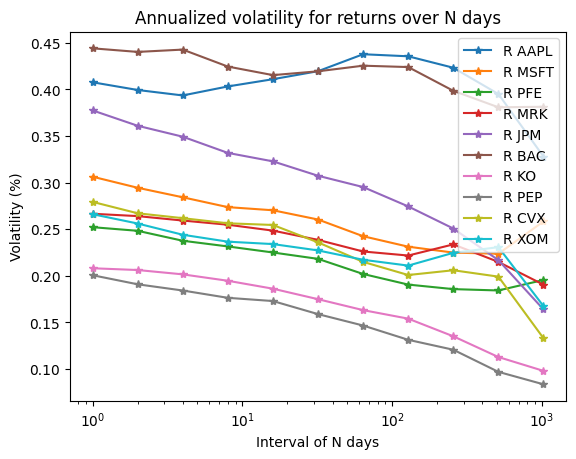

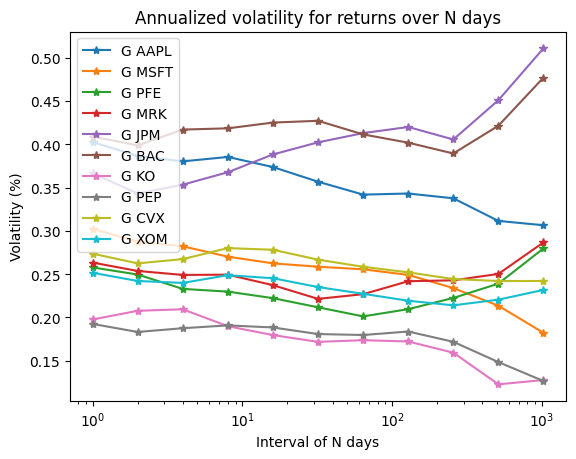

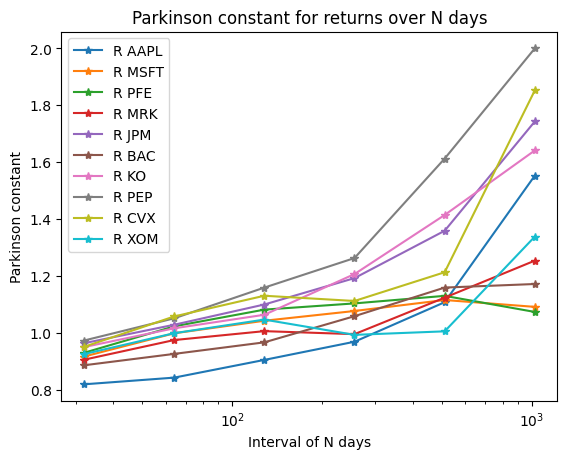

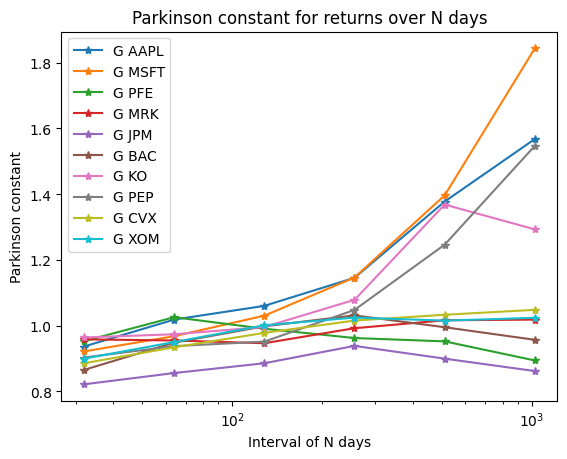

In [25]:
#highs = download_data(start_date, end_date, ticker_list, name_list, "High")
#lows = download_data(start_date, end_date, ticker_list, name_list, "Low")

intervals = np.array([2**x for x in range(10+1)])
plot_vols(intervals, log_returns, ticker_list, dtype="R", show=True)
plot_vols(intervals, generated_data, ticker_list, dtype="G", show=True)

intervals = np.array([2**x for x in range(5, 10+1)])
plot_parkinson(intervals, log_returns, ticker_list, dtype="R", show=True)
plot_parkinson(intervals, generated_data, ticker_list, dtype="G", show=True)

## Plots

#### Generated vs Original log returns

By looking at the log-returns plot from the S&P 500 (figure 7), it is possible to recognize some key patterns. Firstly, the limit in which the returns fluctuate, centered at zero and staying between -10% and 10%.
Second, the clusters of periods with high volatility and low volatility are usually bundled together, as asserted by the stylized fact of volatility clustering. This pattern is visually identifiable, and it is expected that a good synthetic sample resemble the original data by repeating this patterns of clusters.



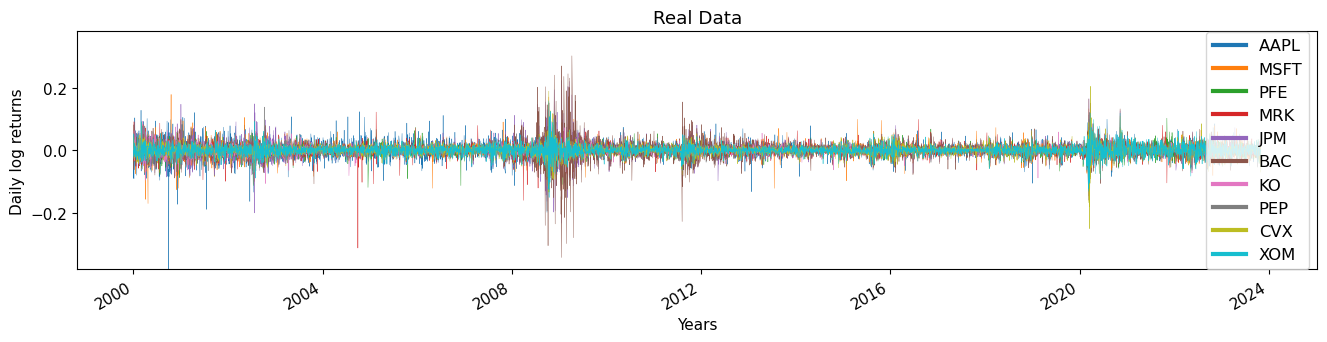

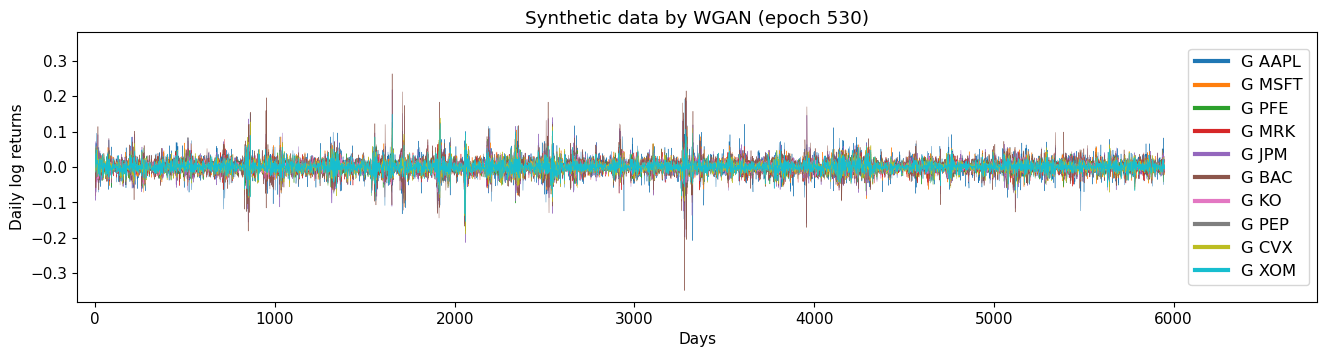

In [50]:
#noise = np.random.randn(157,100)
#predictions = generator(noise, training=True) # TRAINING TRUE OR FALSE
#result = tf.squeeze(predictions) # Given a tensor input, this operation returns a tensor of the same type with all dimensions of size 1 removed.
#temp = (result.numpy())
#generated_data = [item for sublist in temp for item in sublist] # temp is the list getting flattened
#df_generated = pd.DataFrame(generated_data,columns=[f'Generated {name}' for name in name_list])

plt.rcParams["font.size"] = 16

# put them overlapping?
plt.rcParams.update({'font.size': 11})

log_returns2 = log_returns.rename(columns={f"Log Returns {i}": ticker_list[i] for i in range(10)})
log_returns2.div(100).plot(title = "Real Data", lw=0.3, ylim=[-0.38, 0.38], figsize=(16, 3.5), xlabel="Years",
                            ylabel="Daily log returns")

leg = plt.legend(fontsize=11.8, loc="right")
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)
plt.show()

df_generated.div(100).plot(title = "Synthetic data by WGAN (epoch 530)", lw=0.3, ylim=[-0.38, 0.38], figsize=(16, 3.5), xlabel="Days",
                            ylabel="Daily log returns", xlim=[-100, 6800])

leg = plt.legend(fontsize=11.8, loc="right")
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

plt.show()

In [313]:
G_log = pd.DataFrame({f"G {name}": generated_data[:,i] for (i, name) in enumerate(name_list)}).corr()
G_log.style.background_gradient(cmap='coolwarm', vmin=0.0)

,G AAPL,G MSFT,G PFE,G MRK,G JPM,G BAC,G KO,G PEP,G CVX,G XOM
G AAPL,1.000000,0.466103,0.296312,0.203164,0.291784,0.250645,0.322364,0.224405,0.272596,0.280339
G MSFT,0.466103,1.000000,0.355482,0.274858,0.397902,0.350182,0.343070,0.357417,0.372556,0.367472
G PFE,0.296312,0.355482,1.000000,0.588890,0.379925,0.357905,0.342883,0.400266,0.384843,0.413041
G MRK,0.203164,0.274858,0.588890,1.000000,0.360496,0.315578,0.363445,0.387507,0.380318,0.393722
G JPM,0.291784,0.397902,0.379925,0.360496,1.000000,0.787614,0.358254,0.284195,0.455474,0.467212
G BAC,0.250645,0.350182,0.357905,0.315578,0.787614,1.000000,0.345620,0.223541,0.409633,0.395265
G KO,0.322364,0.343070,0.342883,0.363445,0.358254,0.345620,1.000000,0.592578,0.341366,0.401904
G PEP,0.224405,0.357417,0.400266,0.387507,0.284195,0.223541,0.592578,1.000000,0.342887,0.366725
G CVX,0.272596,0.372556,0.384843,0.380318,0.455474,0.409633,0.341366,0.342887,1.000000,0.826636
G XOM,0.280339,0.367472,0.413041,0.393722,0.467212,0.395265,0.401904,0.366725,0.826636,1.000000


In [314]:
R_log = pd.DataFrame({f"R {name}": log_returns.iloc[:,i] for (i, name) in enumerate(name_list)}).corr()
R_log.style.background_gradient(cmap='coolwarm', vmin=0.0)

,R AAPL,R MSFT,R PFE,R MRK,R JPM,R BAC,R KO,R PEP,R CVX,R XOM
R AAPL,1.000000,0.466059,0.214482,0.201513,0.352667,0.306650,0.228029,0.202621,0.264732,0.263700
R MSFT,0.466059,1.000000,0.329659,0.291633,0.447444,0.374081,0.338311,0.347034,0.378942,0.365453
R PFE,0.214482,0.329659,1.000000,0.537755,0.373922,0.352358,0.365822,0.400981,0.381069,0.397756
R MRK,0.201513,0.291633,0.537755,1.000000,0.337210,0.294212,0.352989,0.388439,0.367471,0.370546
R JPM,0.352667,0.447444,0.373922,0.337210,1.000000,0.787650,0.341899,0.328762,0.468695,0.448679
R BAC,0.306650,0.374081,0.352358,0.294212,0.787650,1.000000,0.300299,0.293375,0.445677,0.420152
R KO,0.228029,0.338311,0.365822,0.352989,0.341899,0.300299,1.000000,0.599866,0.379365,0.404192
R PEP,0.202621,0.347034,0.400981,0.388439,0.328762,0.293375,0.599866,1.000000,0.369741,0.385387
R CVX,0.264732,0.378942,0.381069,0.367471,0.468695,0.445677,0.379365,0.369741,1.000000,0.838611
R XOM,0.263700,0.365453,0.397756,0.370546,0.448679,0.420152,0.404192,0.385387,0.838611,1.000000


In [315]:
G_abs = pd.DataFrame({f"G |{name}|": np.abs(generated_data[:,i]) for (i, name) in enumerate(name_list)}).corr()
G_abs.style.background_gradient(cmap='coolwarm', vmin=0.0)

,G |AAPL|,G |MSFT|,G |PFE|,G |MRK|,G |JPM|,G |BAC|,G |KO|,G |PEP|,G |CVX|,G |XOM|
G |AAPL|,1.000000,0.345406,0.266500,0.276419,0.309719,0.330234,0.272859,0.299318,0.246228,0.237711
G |MSFT|,0.345406,1.000000,0.309340,0.304126,0.352771,0.315397,0.296569,0.325467,0.348964,0.341649
G |PFE|,0.266500,0.309340,1.000000,0.481539,0.312452,0.294591,0.291160,0.352168,0.344904,0.333238
G |MRK|,0.276419,0.304126,0.481539,1.000000,0.337805,0.311545,0.302414,0.323756,0.319867,0.323561
G |JPM|,0.309719,0.352771,0.312452,0.337805,1.000000,0.747393,0.347014,0.365907,0.411856,0.381937
G |BAC|,0.330234,0.315397,0.294591,0.311545,0.747393,1.000000,0.366738,0.370268,0.390612,0.341742
G |KO|,0.272859,0.296569,0.291160,0.302414,0.347014,0.366738,1.000000,0.484790,0.373120,0.368056
G |PEP|,0.299318,0.325467,0.352168,0.323756,0.365907,0.370268,0.484790,1.000000,0.383596,0.352794
G |CVX|,0.246228,0.348964,0.344904,0.319867,0.411856,0.390612,0.373120,0.383596,1.000000,0.715264
G |XOM|,0.237711,0.341649,0.333238,0.323561,0.381937,0.341742,0.368056,0.352794,0.715264,1.000000


In [316]:
R_abs = pd.DataFrame({f"R |{name}|": np.abs(log_returns.iloc[:,i]) for (i, name) in enumerate(name_list)}).corr()
R_abs.style.background_gradient(cmap='coolwarm', vmin=0.0)

,R |AAPL|,R |MSFT|,R |PFE|,R |MRK|,R |JPM|,R |BAC|,R |KO|,R |PEP|,R |CVX|,R |XOM|
R |AAPL|,1.000000,0.348993,0.256062,0.195368,0.282626,0.225849,0.248758,0.253352,0.231705,0.217483
R |MSFT|,0.348993,1.000000,0.326824,0.283359,0.416418,0.334483,0.343368,0.350133,0.337854,0.340025
R |PFE|,0.256062,0.326824,1.000000,0.437537,0.354985,0.314285,0.352909,0.367952,0.338728,0.344638
R |MRK|,0.195368,0.283359,0.437537,1.000000,0.307713,0.282219,0.319285,0.324467,0.315761,0.302978
R |JPM|,0.282626,0.416418,0.354985,0.307713,1.000000,0.738117,0.351858,0.337692,0.418571,0.386003
R |BAC|,0.225849,0.334483,0.314285,0.282219,0.738117,1.000000,0.292939,0.287889,0.384668,0.339927
R |KO|,0.248758,0.343368,0.352909,0.319285,0.351858,0.292939,1.000000,0.538888,0.368696,0.366465
R |PEP|,0.253352,0.350133,0.367952,0.324467,0.337692,0.287889,0.538888,1.000000,0.351740,0.354053
R |CVX|,0.231705,0.337854,0.338728,0.315761,0.418571,0.384668,0.368696,0.351740,1.000000,0.769533
R |XOM|,0.217483,0.340025,0.344638,0.302978,0.386003,0.339927,0.366465,0.354053,0.769533,1.000000


In [318]:
cmd(G_log, R_log), cmd(G_abs, R_abs)

(0.001932330308719754, 0.0027558994442878904)

In [319]:
from statsmodels.stats.diagnostic import acorr_ljungbox
i = 0
acorr_ljungbox(log_returns.iloc[:,i])

,lb_stat,lb_pvalue
1,9.785499,0.001759
2,9.788588,0.007489
3,10.793443,0.012897
4,22.070873,0.000194
5,24.142314,0.000204
6,24.721244,0.000385
7,28.738929,0.000161
8,31.097625,0.000135
9,32.161659,0.000187
10,37.588967,0.000045


In [320]:
acorr_ljungbox(generated_data[:,i])

,lb_stat,lb_pvalue
1,64.577949,9.278798e-16
2,69.914227,6.581403e-16
3,122.016500,2.838701e-26
4,144.154170,3.639996e-30
5,149.204952,1.971299e-30
6,149.507804,9.832151e-30
7,181.277660,1.046589e-35
8,186.542052,4.345495e-36
9,196.011559,2.269834e-37
10,231.492978,4.177303e-44


In [349]:
stats.pearsonr(log_returns.iloc[1:,i], log_returns.iloc[:-1,i])[0]

-0.07411869894417984

In [52]:
r_acf = [stats.pearsonr(np.abs(log_returns.iloc[1:,i]), np.abs(log_returns.iloc[:-1,i]))[0] for i in range(len(name_list))]
g_acf = [stats.pearsonr(np.abs(generated_data[1:,i]), np.abs(generated_data[:-1,i]))[0] for i in range(len(name_list))]

print(name_list)
print(" & ".join([f"{n:.3}" for n in r_acf]))
print(" & ".join([f"{n:.3}" for n in g_acf]))

['AAPL', 'MSFT', 'PFE', 'MRK', 'JPM', 'BAC', 'KO', 'PEP', 'CVX', 'XOM']
0.215 & 0.259 & 0.254 & 0.206 & 0.38 & 0.45 & 0.286 & 0.322 & 0.259 & 0.276
0.178 & 0.22 & 0.226 & 0.203 & 0.386 & 0.34 & 0.224 & 0.259 & 0.277 & 0.259


In [55]:
r_acf = [stats.pearsonr(log_returns.iloc[1:,i], log_returns.iloc[:-1,i])[0] for i in range(len(name_list))]
g_acf = [stats.pearsonr(generated_data[1:,i], generated_data[:-1,i])[0] for i in range(len(name_list))]

print(name_list)
print(" & ".join([f"{n:.3f}" for n in r_acf]))
print(" & ".join([f"{n:.3f}" for n in g_acf]))

['AAPL', 'MSFT', 'PFE', 'MRK', 'JPM', 'BAC', 'KO', 'PEP', 'CVX', 'XOM']
-0.040 & -0.076 & -0.031 & -0.019 & -0.086 & -0.017 & -0.018 & -0.095 & -0.086 & -0.074
-0.078 & -0.096 & -0.062 & -0.072 & -0.124 & -0.050 & 0.104 & -0.094 & -0.080 & -0.074


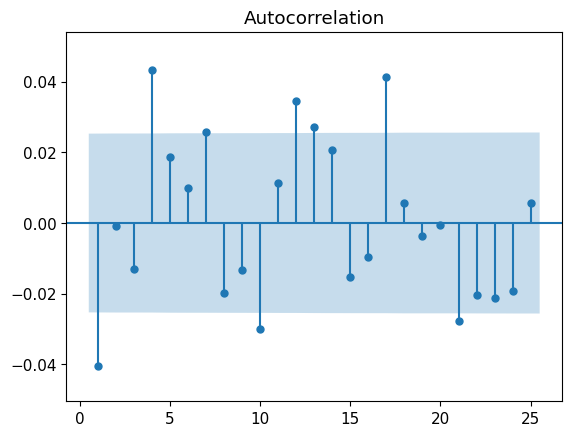

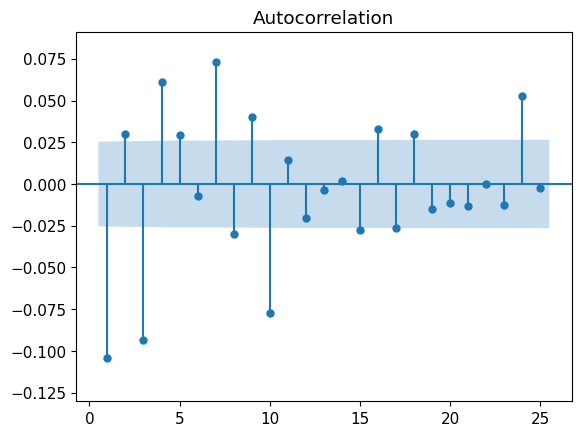

In [352]:
from statsmodels.graphics.tsaplots import plot_acf

i = 0
plot_acf(log_returns.iloc[:,i], zero=False, auto_ylims=True, lags=25)
plt.show()
plot_acf(generated_data[:,i], zero=False, auto_ylims=True, lags=25)
plt.show()

#### Generated vs Original time series

Transforming the generated returns back to prices, for the sake of visualization

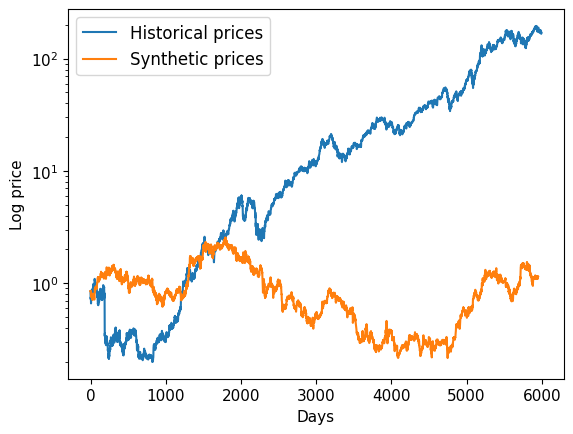

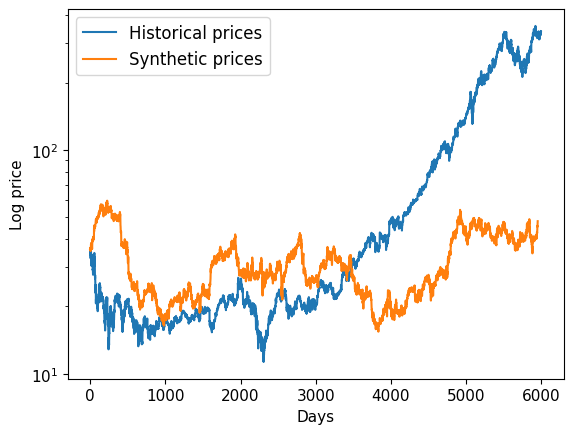

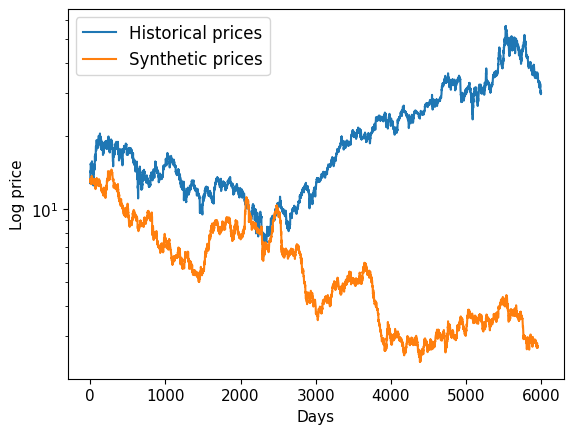

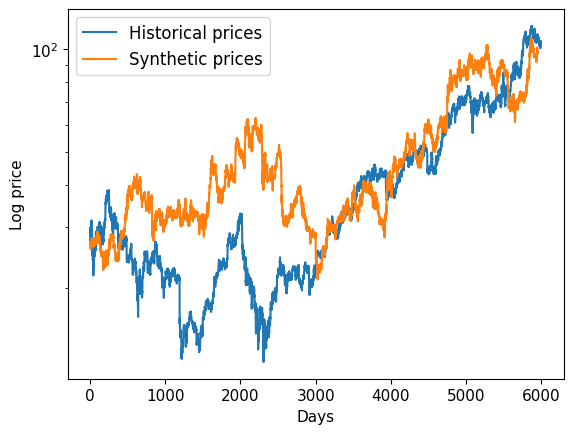

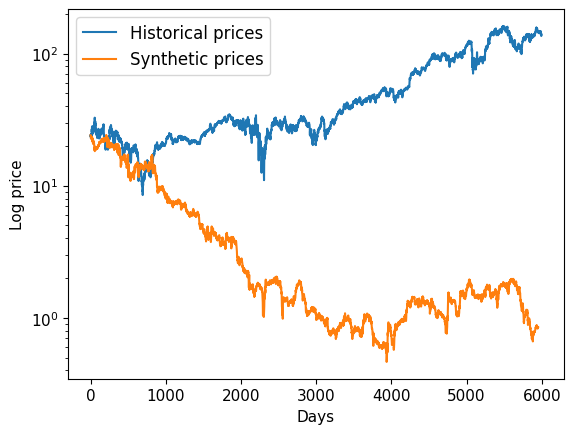

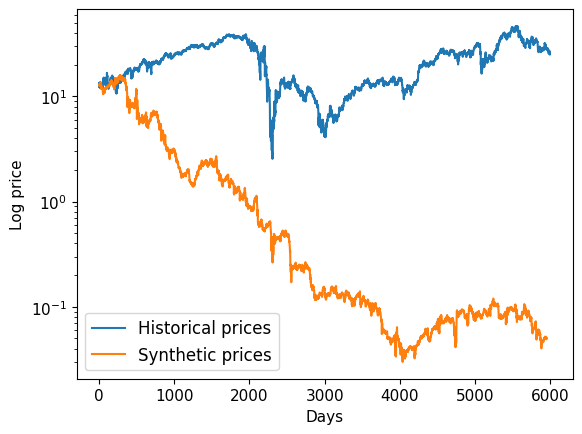

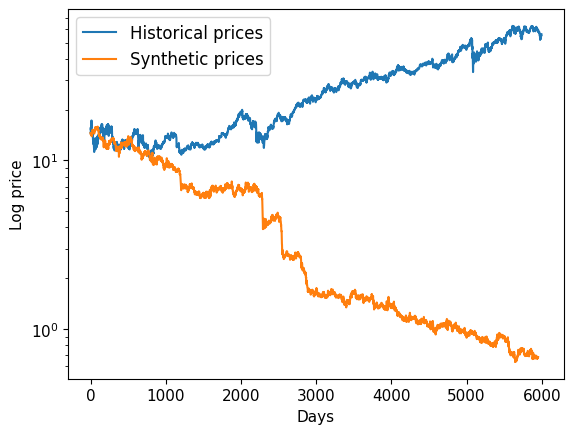

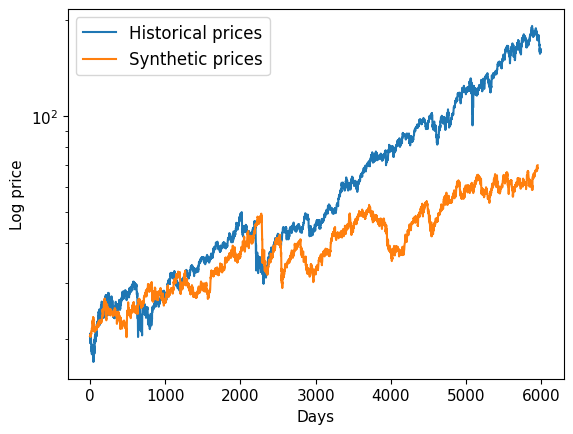

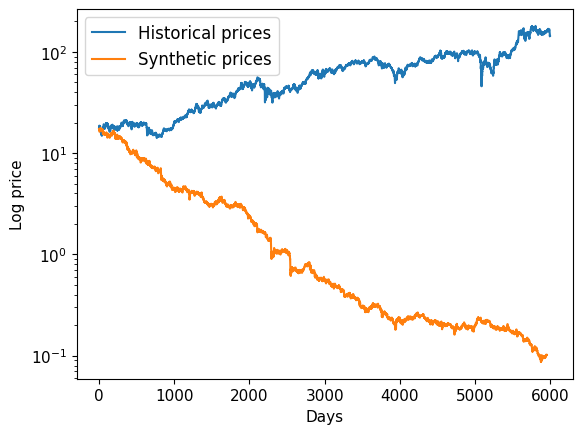

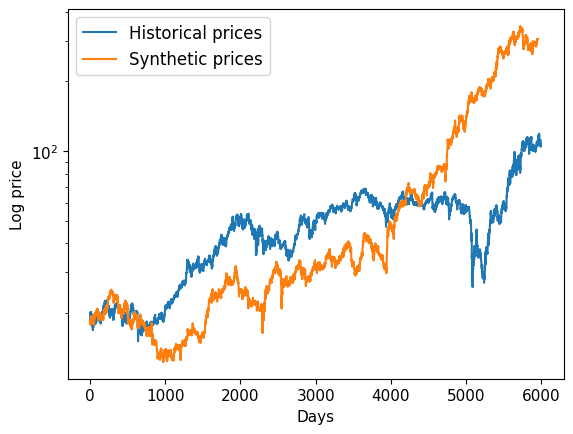

In [324]:
#noise = np.random.randn(157,100)
#predictions = generator(noise, training=True) # TRAINING TRUE OR FALSE
#result = tf.squeeze(predictions) # Given a tensor input, this operation returns a tensor of the same type with all dimensions of size 1 removed.
#temp = (result.numpy())
#generated_data = [item for sublist in temp for item in sublist] # temp is the list getting flattened
#df_generated = pd.DataFrame(generated_data,columns=[f'Generated {name}' for name in name_list])

df12 = df_generated.div(100) # divide by 100 to compensate for training input (x100)
for i in range(len(name_list)):
    df12.iloc[0,i] = 0
    df13 = df12.iloc[:,i].tolist()
    price0 = prices.iloc[0,i] # arbitrary value  1335 on 01.01.2001
    df = pd.DataFrame(df13, columns = ['logreturns'])
    df["logr_na0"] = df.logreturns.fillna(0)
    df['cumlog'] = np.cumsum(df.logr_na0)
    df["norm"] = np.exp(df.cumlog)
    df["prices_back"] = price0 * df.norm

    list_generated = df.iloc[:,4].tolist()
    list_original = prices.iloc[:,i].tolist()
    plt.plot(list_original, label= "Historical prices")
    plt.plot(list_generated, label= "Synthetic prices")
    plt.xlabel("Days")
    plt.ylabel("Log price")
    plt.yscale("log")
    plt.legend(fontsize=12)
    plt.show()

In [ ]:
log_returns.corr()

,Log Returns 0,Log Returns 1,Log Returns 2,Log Returns 3,Log Returns 4,Log Returns 5,Log Returns 6,Log Returns 7,Log Returns 8,Log Returns 9
Log Returns 0,1.000000,0.466059,0.214482,0.201513,0.352668,0.306650,0.228028,0.202620,0.264731,0.263700
Log Returns 1,0.466059,1.000000,0.329659,0.291634,0.447444,0.374081,0.338311,0.347034,0.378942,0.365453
Log Returns 2,0.214482,0.329659,1.000000,0.537754,0.373922,0.352358,0.365821,0.400980,0.381068,0.397755
Log Returns 3,0.201513,0.291634,0.537754,1.000000,0.337210,0.294212,0.352988,0.388439,0.367472,0.370546
Log Returns 4,0.352668,0.447444,0.373922,0.337210,1.000000,0.787650,0.341899,0.328762,0.468695,0.448680
Log Returns 5,0.306650,0.374081,0.352358,0.294212,0.787650,1.000000,0.300300,0.293375,0.445677,0.420152
Log Returns 6,0.228028,0.338311,0.365821,0.352988,0.341899,0.300300,1.000000,0.599865,0.379364,0.404191
Log Returns 7,0.202620,0.347034,0.400980,0.388439,0.328762,0.293375,0.599865,1.000000,0.369741,0.385387
Log Returns 8,0.264731,0.378942,0.381068,0.367472,0.468695,0.445677,0.379364,0.369741,1.000000,0.838612
Log Returns 9,0.263700,0.365453,0.397755,0.370546,0.448680,0.420152,0.404191,0.385387,0.838612,1.000000


In [ ]:
df_generated.corr()

,G AAPL,G MSFT,G PFE,G MRK,G JPM,G BAC,G KO,G PEP,G CVX,G XOM
G AAPL,1.000000,0.342047,0.141722,0.074098,0.415114,0.335307,-0.039726,-0.113871,0.172028,0.215040
G MSFT,0.342047,1.000000,0.114039,0.205662,0.415326,0.122591,0.232403,-0.016767,0.238770,0.415506
G PFE,0.141722,0.114039,1.000000,0.369025,0.263722,0.330028,0.386122,0.349850,0.250885,0.223301
G MRK,0.074098,0.205662,0.369025,1.000000,0.277111,-0.006862,0.250989,0.124044,0.482133,0.449846
G JPM,0.415114,0.415326,0.263722,0.277111,1.000000,0.558536,0.230508,-0.002389,0.176985,0.361501
G BAC,0.335307,0.122591,0.330028,-0.006862,0.558536,1.000000,0.212545,0.134622,0.068443,0.163753
G KO,-0.039726,0.232403,0.386122,0.250989,0.230508,0.212545,1.000000,0.516230,0.245802,0.159447
G PEP,-0.113871,-0.016767,0.349850,0.124044,-0.002389,0.134622,0.516230,1.000000,0.230045,0.146792
G CVX,0.172028,0.238770,0.250885,0.482133,0.176985,0.068443,0.245802,0.230045,1.000000,0.675919
G XOM,0.215040,0.415506,0.223301,0.449846,0.361501,0.163753,0.159447,0.146792,0.675919,1.000000


#### Histograms of generated data

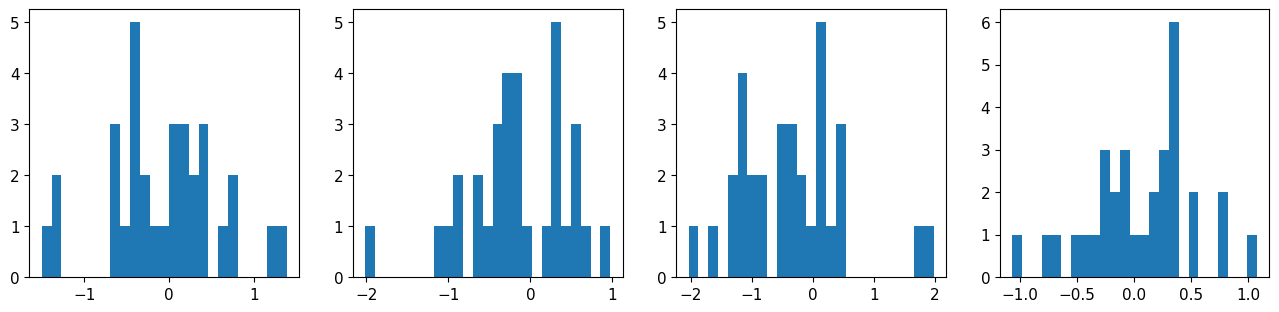

In [ ]:
noise_dim = 100
num_examples_to_generate = 4
test_input = tf.random.normal([num_examples_to_generate, noise_dim])
pred = generator(test_input, training=False) # training = False because we are working on the already trained generator

plot_histogram(pred)

#### ACF
The auto-correlation plots (ACF) show the similarity between observations as a function of time lags between them, for financial returns the autocorrelation it is expected to be very low, given the stylized fact of linear unpredictability.

(0.0, 50.0)

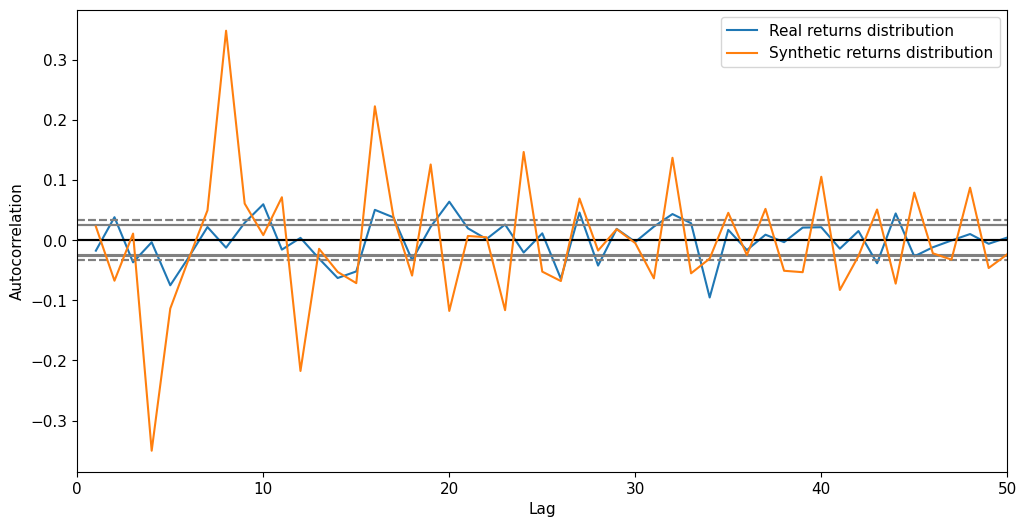

In [ ]:
#ACF
fig, (ax2) = plt.subplots(1, 1, figsize=(12,6))
i = 5
n = 50
autocorrelation_plot(log_returns.iloc[:,i],label='Real returns distribution', ax=ax2).set_xlim([0, n])
autocorrelation_plot(generated_data[:,i], ax=ax2,label='Synthetic returns distribution').set_xlim([0, n])

(0.0, 2000.0)

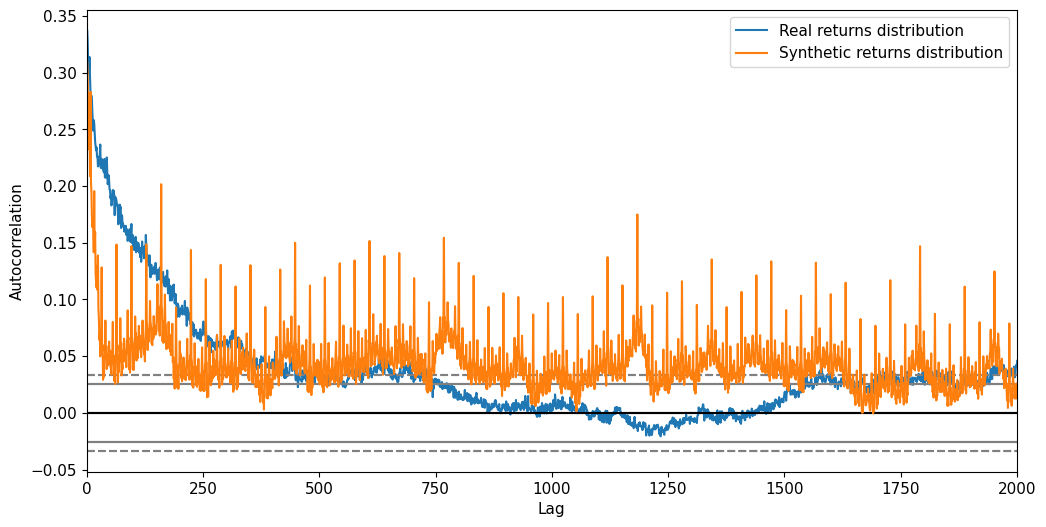

In [ ]:
# ACF of absolute returns
fig, (ax2) = plt.subplots(1, 1, figsize=(12,6))
autocorrelation_plot(np.abs(log_returns),label='Real returns distribution', ax=ax2).set_xlim([0, 2000])
autocorrelation_plot(np.abs(generated_data), ax=ax2,label='Synthetic returns distribution').set_xlim([0, 2000])

#### PDF
Here the generated and real returns are displayed to analyze their distribution and its characteristic skewness and kurtosis measurements.

For a GAN to be qualified as good, it is expected that the synthetic returns distribution resemble the shape of the normal distribution (aggregational gaussianity) and the values for skewness and kurtosis should be close to those from real returns.

In [ ]:
#empirical_pdf(log_returns.iloc[:,0], generated_data)

#### Skewness and Kurtosis

**Skewness** is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. Here it portrays the gain/loss asymmetry of log returns, where it is expected that the skewness be negative, since it is more common to have large downwards movements in stock prices then the contrary.


**Kurtosis** is a measure that defines how much the tails of a given distribution differ from the tails of a normal distribution. It identifies whether there are extreme values in the tails of a distribution. For returns, large values for kurtosis (heavy tails) are expected, since some low probability events have a large impact on the distribution. This behaviour does not happen in a normal distribution, so returns are expected to have the rough shape of a normal distribution, but with much heavier tails.


In [ ]:
"""
sk = []
flt = []
for i in range(0,1000):
    noise = np.random.randn(111,100)
    result = generator(noise)
    result = tf.squeeze(result)
    temp = (result.numpy())
    generated_data = [item for sublist in temp for item in sublist]
    sk.append(skew(generated_data))
    flt.append(kurtosis(generated_data))

fig = plt.figure()
fig.suptitle('Skewness', fontsize=20)
plt.hist(sk, bins=50)

fig = plt.figure()
fig.suptitle('Kurtosis', fontsize=20)
plt.hist(flt, bins=50)
plt.show()
"""